# Transfer Learning with Tensorflow Part 3: Scaling up (🍔👀 Food Vision mini)  
We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).  
Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning). Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf  
Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we're using a gpu
!nvidia-smi

Wed Jun 29 10:27:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-29 10:27:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-29 10:27:29 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions in the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir,compare_historys

## 101 Food Classes: working with less data
Our goal is to beat the original Food101 paper with 10% of the training data, let's download it.  
The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

--2022-06-29 10:27:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.250.81.208, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   136MB/s    in 9.6s    

2022-06-29 10:27:41 (161 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_cl

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes
Here are the steps we're going to take:
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [ ]:
# Create model checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomZoom,RandomFlip,RandomRotation,RandomHeight,RandomWidth
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation = Sequential(
    [
     RandomFlip("horizontal"),
     RandomRotation(0.2),
     RandomHeight(0.2),
     RandomWidth(0.2),
     RandomZoom(0.2),
    #  layers.Rescaling(1/255.0) # Resnet needs rescaling!
    ],name="data_augmentation"
)

In [ ]:
# Setup the base and freeze its layers (this will extract features)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architectrue with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_full_data = model.fit(train_data_all_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_all_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 94s 323ms/step - loss: 3.4568 - accuracy: 0.2508 - val_loss: 2.7627 - val_accuracy: 0.3628
Epoch 2/5
237/237 [==============================] - 61s 256ms/step - loss: 2.3592 - accuracy: 0.4576 - val_loss: 2.2913 - val_accuracy: 0.4462
Epoch 3/5
237/237 [==============================] - 55s 232ms/step - loss: 1.9697 - accuracy: 0.5381 - val_loss: 2.1448 - val_accuracy: 0.4669
Epoch 4/5
237/237 [==============================] - 51s 211ms/step - loss: 1.7545 - accuracy: 0.5674 - val_loss: 2.0310 - val_accuracy: 0.4767
Epoch 5/5
237/237 [==============================] - 46s 191ms/step - loss: 1.6051 - accuracy: 0.6092 - val_loss: 1.9758 - val_accuracy: 0.4849


In [ ]:
# Evaluate on the whole test data
fine_tuning_result=model.evaluate(test_data)
fine_tuning_result

790/790 [==============================] - 57s 72ms/step - loss: 1.7076 - accuracy: 0.5539


[1.7075529098510742, 0.5538613796234131]

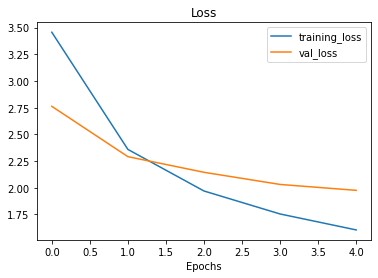

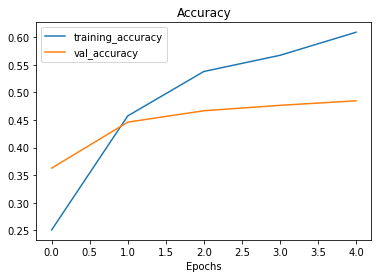

In [ ]:
plot_loss_curves(history_full_data)

> 🤔**Question:** What do these curves suggest?  
*Hint:* ideally, the two curves should be similar to each other, if not, it may suggest that our model is **overfitting** (performing too well on the training data).

## Fine tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable=True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer, in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fitne tune the model
fine_tuning_epochs = 10

# Fit the model
history_full_data_fine_tuned = model.fit(train_data_all_10_percent,
                                         epochs=fine_tuning_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         initial_epoch=history_full_data.epoch[-1])

Epoch 5/10
237/237 [==============================] - 55s 203ms/step - loss: 1.3586 - accuracy: 0.6481 - val_loss: 1.9529 - val_accuracy: 0.4836
Epoch 6/10
237/237 [==============================] - 42s 176ms/step - loss: 1.2378 - accuracy: 0.6726 - val_loss: 1.9226 - val_accuracy: 0.4942
Epoch 7/10
237/237 [==============================] - 43s 179ms/step - loss: 1.1610 - accuracy: 0.6899 - val_loss: 1.9478 - val_accuracy: 0.4918
Epoch 8/10
237/237 [==============================] - 40s 166ms/step - loss: 1.0879 - accuracy: 0.7114 - val_loss: 1.9568 - val_accuracy: 0.4907
Epoch 9/10
237/237 [==============================] - 40s 166ms/step - loss: 1.0183 - accuracy: 0.7341 - val_loss: 1.8854 - val_accuracy: 0.5077
Epoch 10/10
237/237 [==============================] - 38s 161ms/step - loss: 0.9651 - accuracy: 0.7457 - val_loss: 1.9170 - val_accuracy: 0.5045


In [ ]:
# Evaluate on whole test data
all_classes_fine_tune_results = model.evaluate(test_data)
all_classes_fine_tune_results

790/790 [==============================] - 56s 71ms/step - loss: 1.6163 - accuracy: 0.5753


[1.6162887811660767, 0.5753267407417297]

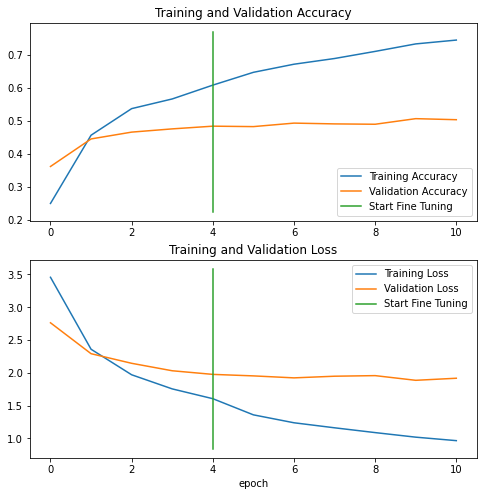

In [ ]:
# Compare the histories of feature extraction model with fine-tuning
compare_historys(original_history=history_full_data,new_history=history_full_data_fine_tuned)

## Saving and loading our model

To use our model in an aexternal application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuning model
model.save("drive/MyDrive/tf_models/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tf_models/101_food_classes_10_percent_saved_big_dog_model/assets


In [ ]:
# Load and evaluate saved model
loaded_model=tf.keras.models.load_model("drive/MyDrive/tf_models/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evalaute loaded model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 73ms/step - loss: 1.6163 - accuracy: 0.5753


[1.6162887811660767, 0.5753267407417297]

In [ ]:
all_classes_fine_tune_results

[1.6162887811660767, 0.5753267407417297]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [ ]:
import tensorflow as tf

# Download pre-trained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-29 10:45:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 172.217.1.208, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   102MB/s    in 0.4s    

2022-06-29 10:45:10 (102 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 59s 73ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 61s 75ms/step


In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# Lets see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541952e-02, 3.5742082e-06, 4.1376974e-02, ..., 1.4138680e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780576e-04, ..., 5.4286946e-05,
        7.8362811e-12, 9.8466213e-10],
       [9.5925879e-01, 3.2533622e-05, 1.4866935e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275776e-05],
       ...,
       [4.7313267e-01, 1.2931186e-07, 1.4805621e-03, ..., 5.9750048e-04,
        6.6968976e-05, 2.3469211e-05],
       [4.4571947e-02, 4.7265419e-07, 1.2258486e-01, ..., 6.3498483e-06,
        7.5318626e-06, 3.6778681e-03],
       [7.2438961e-01, 1.9249808e-09, 5.2310945e-05, ..., 1.2291385e-03,
        1.5792746e-09, 9.6395852e-05]], dtype=float32)

In [ ]:
# Whta does the first prediction look like
preds_probs[0]

array([5.95419519e-02, 3.57420822e-06, 4.13769744e-02, 1.06605547e-09,
       8.16142798e-09, 8.66396554e-09, 8.09271114e-07, 8.56526640e-07,
       1.98590151e-05, 8.09776168e-07, 3.17277427e-09, 9.86738314e-07,
       2.85322167e-04, 7.80493392e-10, 7.42300879e-04, 3.89163397e-05,
       6.47404340e-06, 2.49773279e-06, 3.78911318e-05, 2.06783056e-07,
       1.55384496e-05, 8.15069370e-07, 2.62305412e-06, 2.00106655e-07,
       8.38272967e-07, 5.42159842e-06, 3.73909279e-06, 1.31505820e-08,
       2.77614314e-03, 2.80519198e-05, 6.85624113e-10, 2.55748309e-05,
       1.66888960e-04, 7.64069974e-10, 4.04528371e-04, 1.31506335e-08,
       1.79573772e-06, 1.44482158e-06, 2.30628997e-02, 8.24667779e-07,
       8.53657696e-07, 1.71386114e-06, 7.05252342e-06, 1.84021669e-08,
       2.85532963e-07, 7.94833795e-06, 2.06815525e-06, 1.85251338e-07,
       3.36196422e-08, 3.15225538e-04, 1.04109122e-05, 8.54483574e-07,
       8.47418606e-01, 1.05554345e-05, 4.40945854e-07, 3.74041447e-05,
      

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one orediction probabilty per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilites for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95419519e-02 3.57420822e-06 4.13769744e-02 1.06605547e-09
 8.16142798e-09 8.66396554e-09 8.09271114e-07 8.56526640e-07
 1.98590151e-05 8.09776168e-07 3.17277427e-09 9.86738314e-07
 2.85322167e-04 7.80493392e-10 7.42300879e-04 3.89163397e-05
 6.47404340e-06 2.49773279e-06 3.78911318e-05 2.06783056e-07
 1.55384496e-05 8.15069370e-07 2.62305412e-06 2.00106655e-07
 8.38272967e-07 5.42159842e-06 3.73909279e-06 1.31505820e-08
 2.77614314e-03 2.80519198e-05 6.85624113e-10 2.55748309e-05
 1.66888960e-04 7.64069974e-10 4.04528371e-04 1.31506335e-08
 1.79573772e-06 1.44482158e-06 2.30628997e-02 8.24667779e-07
 8.53657696e-07 1.71386114e-06 7.05252342e-06 1.84021669e-08
 2.85532963e-07 7.94833795e-06 2.06815525e-06 1.85251338e-07
 3.36196422e-08 3.15225538e-04 1.04109122e-05 8.54483574e-07
 8.47418606e-01 1.05554345e-05 4.40945854e-07 3.74041447e-05
 3.53061914e-05 3.24890389e-05 6.73146787e-0

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y labels
len(y_labels)

25250

## Evaluate our model's predcitions
One way to check that our model's predictions araay is in the same order as our test labels array is to find the accuracy score.

In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6077623762376237

## Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
# We need to make changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

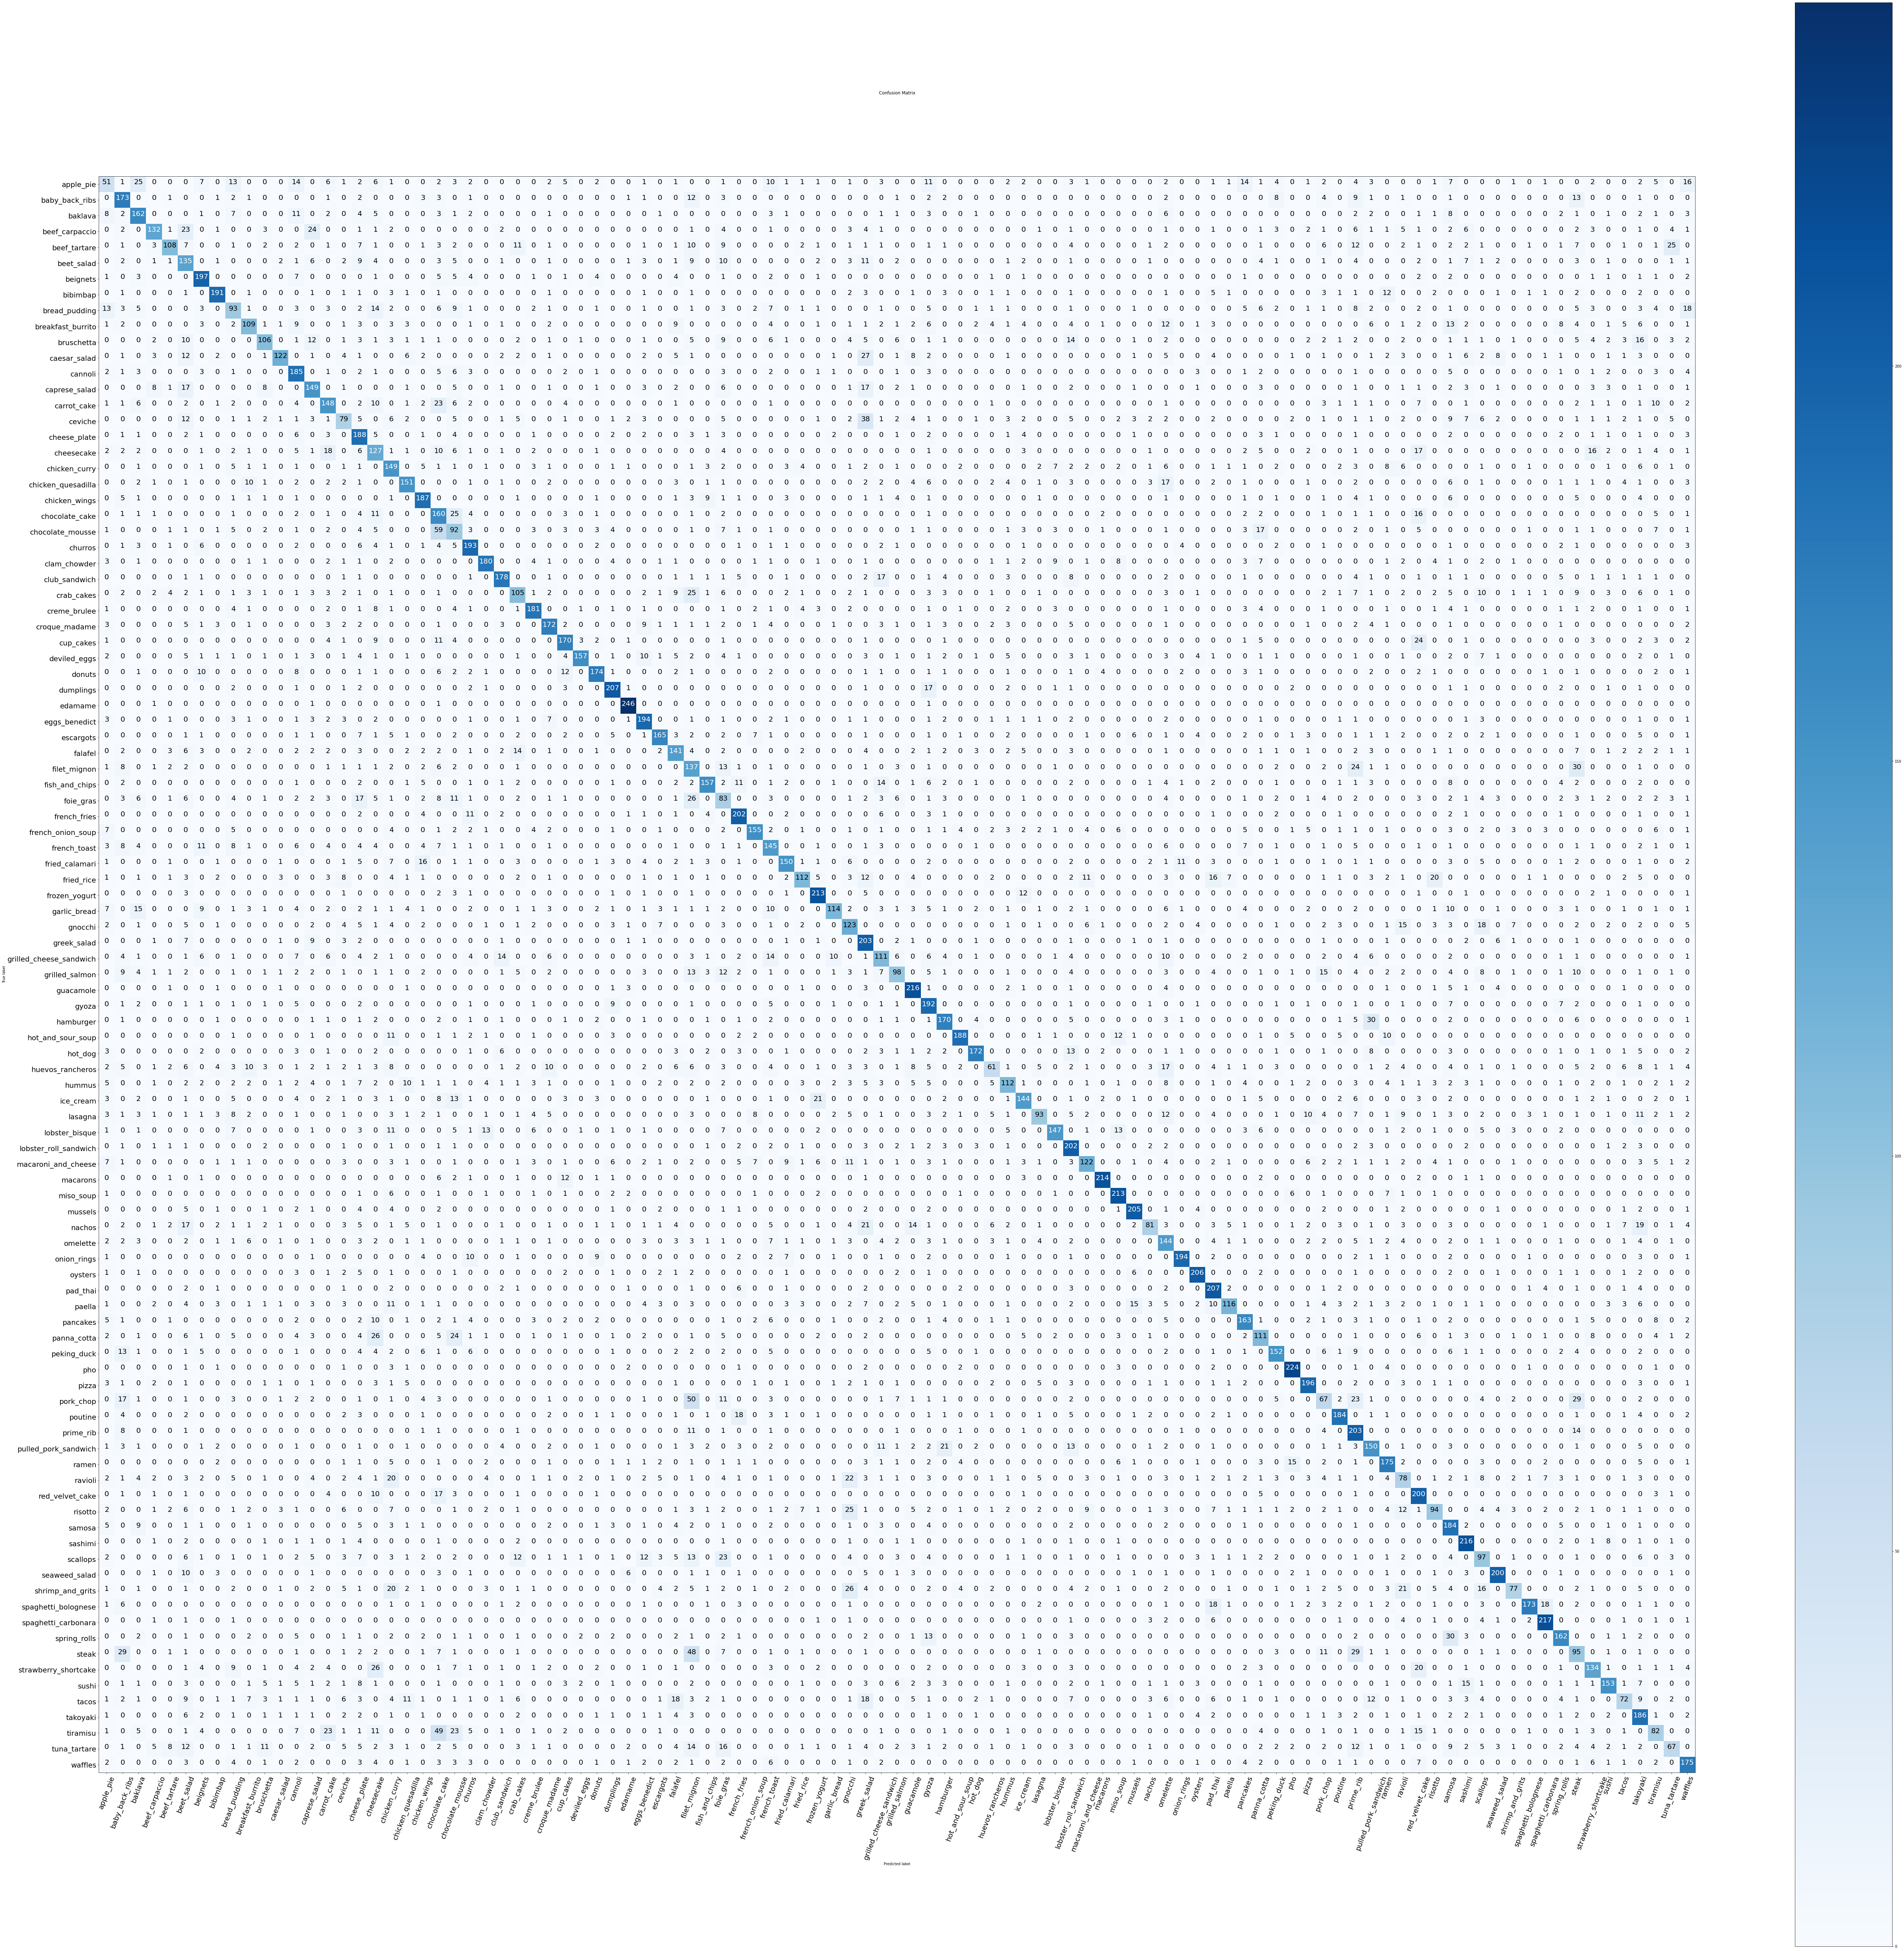

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and f1 score) called `classification_report`

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.  
How about we create a visualization to get a better understanding.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Let's plot all of our classes f1-scores...

In [ ]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k,v in classification_report_dict.items():
  if k=="accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)
f1_scores.head()

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008


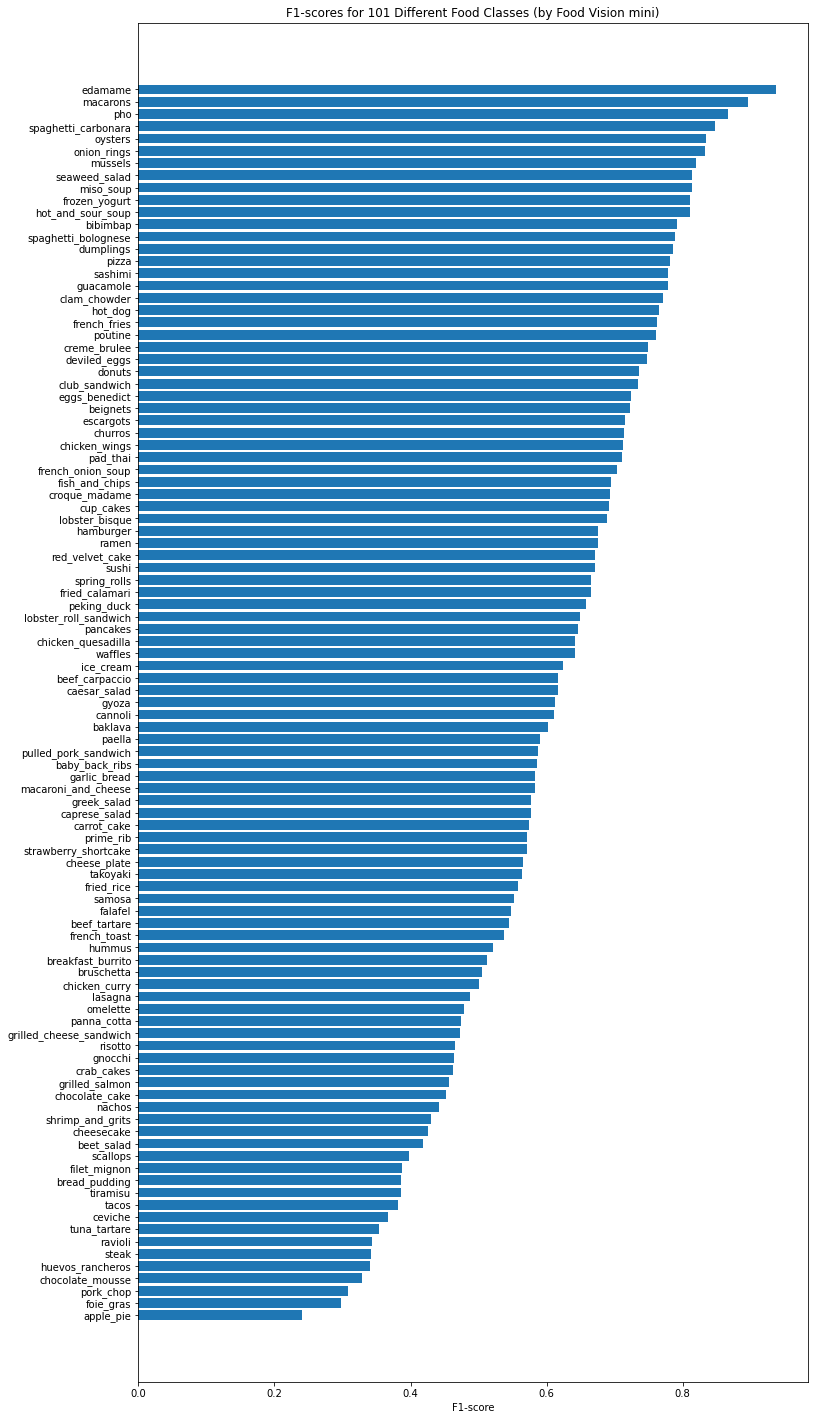

In [ ]:
fig,ax= plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (by Food Vision mini)")
ax.invert_yaxis();

## Visualizing predictions on custom images
Now, this is the real test, how does our molde go on food images not even in our test dataset (images of our own).  
To visualize our model's predictions on our own images , we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* *If necessary*, scale the images to get all of the pixerl values between 0 & 1

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to the image file
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape,img_shape,3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img,channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  # Scale? Yes/No
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.0
  return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and model's predictions.  
Specifically, we'll write some code to:
1. Load a few random images from the test dataset.
2. Make predictions on the loaded images.
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label.

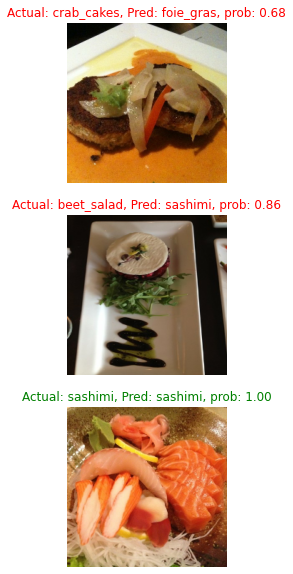

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir+class_name+"/"+filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prod = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prod.argmax()]
  
  # Plot the images
  plt.subplot(3,1,i+1)
  plt.imshow(img/255.0)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color= "r"
  plt.title(f"Actual: {class_name}, Pred: {pred_class}, prob: {pred_prod.max():.2f}",c=title_color)
  plt.axis(False);

## Finding the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted class, max prediction probabilites
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the perdiction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong predictions.

In [ ]:
# Get all of the image file paths in the test dataset
filepaths=[]
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df=pd.DataFrame({"img_path": filepaths,
                      "y_true":y_labels,
                      "y_pred":pred_classes,
                      "pred_conf":preds_probs.max(axis=1),
                      "y_true_classname":[class_names[i] for i in y_labels],
                      "y_pred_classname":[class_names[i] for i in pred_classes]})
pred_df.head(10)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367900,apple_pie,prime_rib
5,b'/content/101_food_classes_10_percent/test/ap...,0,61,0.456755,apple_pie,lobster_roll_sandwich
6,b'/content/101_food_classes_10_percent/test/ap...,0,29,0.611242,apple_pie,cup_cakes
7,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.473133,apple_pie,apple_pie
8,b'/content/101_food_classes_10_percent/test/ap...,0,85,0.245397,apple_pie,samosa
9,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.724390,apple_pie,apple_pie


In [ ]:
pred_df["pred_correct"] = pred_df["y_true"]==pred_df["y_pred"]
pred_df.head(10)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367900,apple_pie,prime_rib,False
5,b'/content/101_food_classes_10_percent/test/ap...,0,61,0.456755,apple_pie,lobster_roll_sandwich,False
6,b'/content/101_food_classes_10_percent/test/ap...,0,29,0.611242,apple_pie,cup_cakes,False
7,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.473133,apple_pie,apple_pie,True
8,b'/content/101_food_classes_10_percent/test/ap...,0,85,0.245397,apple_pie,samosa,False
9,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.724390,apple_pie,apple_pie,True


In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(10)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
24540,b'/content/101_food_classes_10_percent/test/ti...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'/content/101_food_classes_10_percent/test/br...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'/content/101_food_classes_10_percent/test/ch...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'/content/101_food_classes_10_percent/test/pa...,71,65,0.999931,paella,mussels,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.999904,sushi,sashimi,False


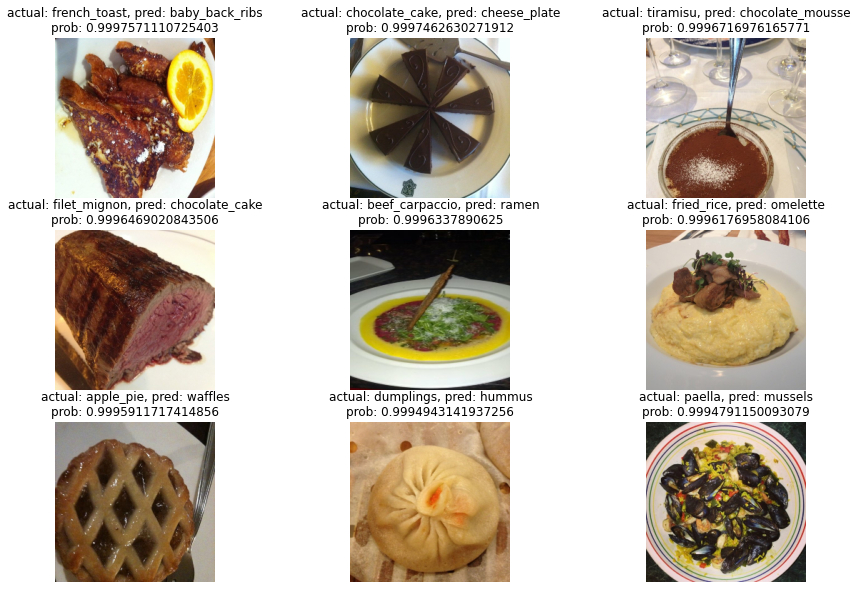

In [ ]:
IMAGES_TO_VIEW=9
START_INDEX = 20
plt.figure(figsize=(15,10))
for i , row in enumerate(top_100_wrong[START_INDEX:START_INDEX+IMAGES_TO_VIEW].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1],scale=False)
  _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_=row
  plt.imshow(img/255.0)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}\nprob: {pred_prob}")
  plt.axis(False);

## Test out the big dog model on ouw own custom images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2022-06-29 10:52:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 142.251.45.16, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  37.7MB/s    in 0.3s    

2022-06-29 10:52:23 (37.7 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepath
custom_food_images = ["custom_food_images/"+ img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg']

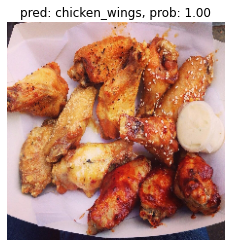

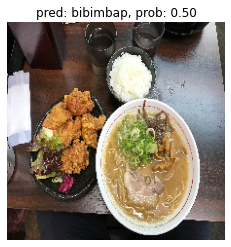

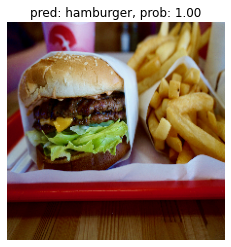

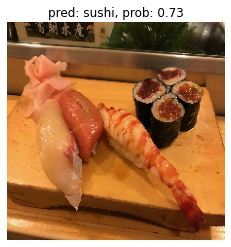

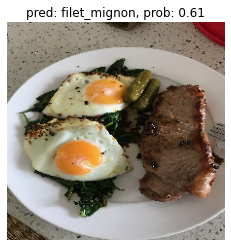

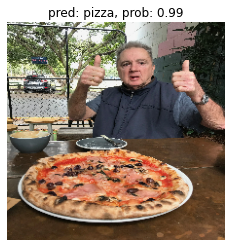

In [ ]:
# Make predictions on adn plot custom food images
for img in custom_food_images:
  img  = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.0)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);